In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# from selenium import webdriver
import os
import requests
import re
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.layers import BatchNormalization
import datetime
import cv2

In [2]:
# 이미 저장된 이미지를 읽어오는 함수입니다. 경로 수정 필요
# 흑백 이미지도, jpeg로 저장하면 3채널이 됩니다. 그래서 단일 채널로 변환이 필요.
def get_image(number):
    img_name = 'camera_image'+str(number)+'.jpeg'
    image = cv2.imread(os.path.join(os.getcwd(), 'images3_resized', img_name))[:,:,0]
#     image = cv2.imread(os.path.join('/','home','hyun','catkin_ws','src','knu_prj','images3_resized',img_name), cv2.IMREAD_ANYCOLOR)
    return image   

In [3]:
# 폴더에 존재하는 모든 이미지를 load하는 부분입니다. (총 11677장)
# 매번 numpy array에 vstack으로 붙이면 속도가 상당히 느린데,
# 100장을 붙인 뒤 이것을 한 번에 붙이면 속도가 빨라집니다.

cnt = 0
number = 2
train_images = np.array(get_image(1))

while True:
    try:
        image = get_image(number)
        if cnt == 0:
            tmp = image
        else:
            tmp = np.vstack((tmp,image))
            if cnt == 100:
                train_images = np.vstack((train_images, tmp))
                cnt = -1
        cnt += 1
        number += 1
        if(number%1000 == 0):
            print(number)
    except:
        train_images = np.vstack((train_images, tmp))
        print("Image load Completed! ", number-1, "driving image loaded")
        break
        
drive_x = np.reshape(train_images, [int(train_images.shape[0]/224),224, 224])
drive_x.shape 

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
Image load Completed!  11677 driving image loaded


(11677, 224, 224)

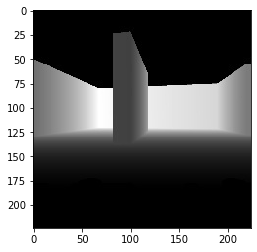

In [4]:
# load된 이미지 테스트
imag1 = drive_x[0]
plt.imshow(imag1, 'gray')

In [5]:
# 이미지를 큰 사이즈로 새로 획득한 경우, 작은 사이즈로 resize 후 다시 저장하는 코드
# for i in range(train_set.shape[0]):
#     num = i+1
#     img_name = "camera_image" + str(num) + ".jpeg"
#     cv2.imwrite(os.path.join('/','home','hyun','catkin_ws','src','knu_prj',[path to save],img_name), train_set[i])

In [6]:
# 각 이미지에 대응하는 직진속도 및 회전속도가 저장된 txt파일 데이터를 load하는 코드
# f = open(os.path.join('/','home','hyun','catkin_ws','src','knu_prj','label3.txt'),'r')
f = open(os.path.join(os.getcwd(), 'label3.txt'),'r')
labels = f.read()
labels

'0.15 -0.04\n0.15 -0.04\n0.15 -0.05\n0.15 -0.05\n0.15 -0.05\n0.15 -0.05\n0.15 -0.02\n0.15 -0.02\n0.15 -0.02\n0.15 -0.02\n0.0 0.0\n0.22 0.32\n0.22 0.32\n0.23 0.4\n0.23 0.4\n0.23 0.4\n0.23 0.4\n0.23 0.4\n0.25 0.47\n0.25 0.47\n0.25 0.47\n0.25 0.47\n0.25 0.46\n0.25 0.46\n0.25 0.46\n0.25 0.41\n0.25 0.41\n0.25 0.41\n0.25 0.41\n0.25 0.41\n0.25 0.41\n0.25 0.41\n0.25 0.41\n0.25 0.41\n0.25 0.41\n0.25 0.4\n0.25 0.4\n0.25 0.4\n0.25 0.4\n0.25 0.4\n0.25 0.44\n0.25 0.44\n0.25 0.44\n0.25 0.44\n0.25 0.44\n0.25 0.43\n0.25 0.43\n0.25 0.43\n0.24 0.38\n0.24 0.38\n0.24 0.38\n0.25 0.41\n0.25 0.41\n0.25 0.41\n0.25 0.41\n0.25 0.39\n0.25 0.39\n0.25 0.39\n0.25 0.39\n0.25 0.39\n0.25 0.45\n0.25 0.45\n0.25 0.45\n0.25 0.45\n0.25 0.42\n0.25 0.33\n0.25 0.33\n0.25 0.33\n0.25 0.33\n0.25 0.4\n0.25 0.4\n0.25 0.4\n0.25 0.4\n0.25 0.37\n0.25 0.37\n0.25 0.37\n0.25 0.37\n0.25 0.37\n0.23 0.35\n0.23 0.35\n0.23 0.35\n0.23 0.35\n0.23 0.35\n0.23 0.35\n0.23 0.35\n0.23 0.35\n0.22 0.32\n0.22 0.32\n0.22 0.32\n0.23 0.23\n0.23 0.23\n0.23

In [7]:
# 읽어온 데이터를 parsing하기 위한 정규표현식 (re)
# '[0-9]', '[a-z]', '[A-Z]' : 해당 구간 안에 있는 문자 하나, .은 모든 문자 하나를 의미합니다.
# [0-9] 뒤에 붙이는 *, + 은 해당 문자의 개수를 의미합니다.
# [0-9]+는 0~9 사이의 문자가 최소 하나는 있어야 한다는 규칙, [0-9]*는 없어도 되고 있어도 되고.
comp = re.compile('[0-9]*.[0-9]* ')
comp2 = re.compile('-*[0-9]*.[0-9]*\n')

In [8]:
# compile한 규칙에 해당하는 모든 문자열을 찾습니다. comp : 직진속도, comp2 : 회전속도
x_linear = comp.findall(labels)
z_angular = comp2.findall(labels)
print(x_linear[:5])
print(z_angular[:5])

['0.15 ', '0.15 ', '0.15 ', '0.15 ', '0.15 ']
['-0.04\n', '-0.04\n', '-0.05\n', '-0.05\n', '-0.05\n']


In [9]:
drive_x.shape

(11677, 224, 224)

In [10]:
drive_y = []
for i in range(12000):
    try:
        # 문자열 EOF까지, 뒤에 공백이랑, \n 제외하고 list로 연결한다.
        drive_y.append([float(x_linear[i][:-1]), float(z_angular[i][:-2])])
    except:
        drive_y = np.array(drive_y)
        break

In [11]:
drive_y.shape

(11677, 2)

In [12]:
drive_y[:5]

array([[ 0.15, -0.  ],
       [ 0.15, -0.  ],
       [ 0.15, -0.  ],
       [ 0.15, -0.  ],
       [ 0.15, -0.  ]])

In [13]:
# 속도 데이터로부터 labeling하는 부분.
# 마음대로 조절하면 됩니다. Angular velocity가 양수 : 좌회전, 음수 : 우회전.
# Label :
# 0 = 좌회전, 1 = 직진, 2 = 우회전

drive_y_labeled = []
for y in drive_y:
    # 직진속도기 일정 값 이상인 경우
    if y[0] >= 0.1:
        # 우회전
        if y[1] <= -0.09:
            drive_y_labeled.append(2)
        # 좌회전
        elif y[1] >= 0.09:
            drive_y_labeled.append(0)
        # 직진
        else:
            drive_y_labeled.append(1)
    # 속도가 낮은 경우는 별도의 labeling
    else:
        drive_y_labeled.append(3)
        

In [14]:
print(drive_y[0])
print(drive_y_labeled[0])

[ 0.15 -0.  ]
1


In [15]:
drive_y_labeled = np.array(drive_y_labeled)
drive_x.shape, drive_y_labeled.shape

((11677, 224, 224), (11677,))

In [16]:
# label = 3 인 경우 몇 갠지 세보기 (258개)
cnt=0
for i in range(11677):
    if drive_y_labeled[i] == 3:
        cnt += 1
cnt

258

In [17]:
# 충돌 이미지 load (1198장)

number = 1
while number <= 1300:
    try:
        if number % 100==0:
            print(number)
        img_name = "camera_image" + str(number) + ".jpeg"
#         image2 = cv2.imread(os.path.join('/','home','hyun','catkin_ws','src','knu_prj','images_collision',img_name), cv2.IMREAD_ANYCOLOR)
        col_image = cv2.imread(os.path.join(os.getcwd(),'images_collision',img_name), cv2.IMREAD_ANYCOLOR)
        resized_image = np.array(cv2.resize(col_image, dsize=(224,224), interpolation=cv2.INTER_LINEAR))
        if number == 1:
            col_images = np.array(resized_image)
        else:
            col_images = np.vstack((col_images, resized_image))
        number += 1
    except:
        number += 1

col_x = np.reshape(col_images, [int(col_images.shape[0]/224), 224, 224])        
col_x.shape

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


(1198, 224, 224)

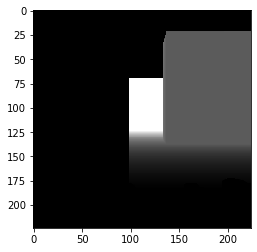

In [18]:
# Collision image test
plt.imshow(col_x[200], 'gray')

In [19]:
# number = 1

# while number <= 10:
#     try:
#         print(number)
#         img_name = "camera_image" + str(number) + ".jpeg"
#         image2 = cv2.imread(os.path.join('/','home','hyun','catkin_ws','src','knu_prj','images_collision_new',img_name), cv2.IMREAD_ANYCOLOR)
#         resized_image = np.array(cv2.resize(image2, dsize=(224,224), interpolation=cv2.INTER_LINEAR))
#         if number == 1:
#             train_images3 = np.array(resized_image)
#         else:
#             train_images3 = np.vstack((train_images3, resized_image))
#         number += 1
#     except:
#         number += 1

In [20]:
# 1198개의 이미지를 10배 복제해서 이미지 개수 대충 맞춰주기
col_x2 = [col_x for i in range(10)]
col_x2 = np.array(col_x2).reshape(-1,224,224)
col_x2.shape

(11980, 224, 224)

In [21]:
# 충돌 이미지 Labeling : [좌회전 확률, 직진 확률, 우회전 확률, 충돌 확률] 각각 [0.5, 0, 0.5, 1.0]
col_y = np.array([[0.5, 0., 0.5, 1.] for i in range(col_x2.shape[0])], 'float32')
col_y[:5]

array([[0.5, 0. , 0.5, 1. ],
       [0.5, 0. , 0.5, 1. ],
       [0.5, 0. , 0.5, 1. ],
       [0.5, 0. , 0.5, 1. ],
       [0.5, 0. , 0.5, 1. ]], dtype=float32)

In [22]:
drive_y_labeled

array([1, 1, 1, ..., 2, 2, 3])

In [23]:
# Classification을 위해 one-hot encoding하는 것.

# 0 -> [1., 0., 0., 0.]
# 1 -> [0., 1., 0., 0.]
# 2 -> [0., 0., 1., 0.]
# 3 -> [0., 0., 0., 1.]

# 이렇게 하면 학습할 때 4개의 객체가 각각 값을 1, 0, 0, 0씩 갖고 있다고 생각하고 손실 함수 등을 계산할 수 있다.

drive_y_labeled = tf.keras.utils.to_categorical(
    drive_y_labeled, num_classes=4, dtype='float32'
)
drive_y_labeled[:5]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [24]:
# 속도가 안되서 Label이 3으로 분류된 267장에 대해, 좌,직,우 각각 0.25, 0.5, 0.25, 충돌확률 0.5로 분류주기.
for i in range(len(drive_y_labeled)):
    if drive_y_labeled[i][3] == 1:
        drive_y_labeled[i] = [0.25, 0.5, 0.25, 0.5]

In [25]:
drive_x.shape, col_x2.shape

((11677, 224, 224), (11980, 224, 224))

In [26]:
drive_y_labeled.shape, col_y.shape

((11677, 4), (11980, 4))

In [27]:
# 주행 데이터와 충돌 데이터를 결합한다.
data_x = np.append(drive_x, col_x2, axis=0)
data_y = np.append(drive_y_labeled, col_y, axis=0)

In [28]:
data_x.shape, data_y.shape

((23657, 224, 224), (23657, 4))

In [29]:
# 해당 데이터를 함께 섞는다.

from sklearn.utils import shuffle
data_x, data_y = shuffle(data_x, data_y)

In [30]:
# 학습을 위해 이미지 데이터에 채널 하나를 추가한다.

data_x = data_x[...,np.newaxis]
data_x.shape, data_y.shape

((23657, 224, 224, 1), (23657, 4))

In [31]:
# train : test = 7 : 3으로 나눈다.
ratio = 0.7
pivot = int(data_x.shape[0]*ratio)
train_x = data_x[:pivot]
test_x = data_x[pivot:]
train_y = data_y[:pivot]
test_y = data_y[pivot:]

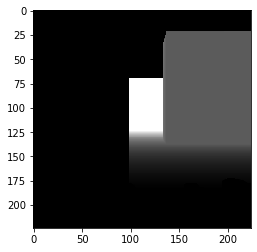

In [32]:
plt.imshow(train_x[100,:,:,0], 'gray')

In [33]:
# 각 클래스 별로 학습 데이터 분포 확인

cnt = [0, 0, 0, 0, 0]
for i in range(len(train_y)):
    # 좌회전
    if train_y[i][0] == 1.:
        cnt[0] += 1
    # 직진
    elif train_y[i][1] == 1.:
        cnt[1] += 1
    # 우회전
    elif train_y[i][2] == 1.:
        cnt[2] += 1
    # 덜직진
    elif train_y[i][1] == 0.5:
        cnt[3] += 1
    # 충돌하는 경우
    else:
        cnt[4] += 1

# [좌회전, 직진, 우회전, 속도작음, 충돌] 학습 이미지 개수 (차이가 나서 학습에 편향이 생길 수 있음.)
cnt

[2176, 2689, 3061, 183, 8450]

In [34]:
# 정답 이미지 개수를 맞춰준다.
train_y_real = []
train_x_real = []
cnt = [0, 0, 0, 0, 0]
for i in range(len(train_y)):
    if train_y[i][0] == 1.:
        if cnt[0]>= 2000:
            pass
        else:
            train_x_real.append(train_x[i])
            train_y_real.append(train_y[i])
            cnt[0] += 1
    elif train_y[i][1] == 1.:
        if cnt[1] >= 2000:
            pass
        else:
            train_x_real.append(train_x[i])
            train_y_real.append(train_y[i])
            cnt[1] += 1
    elif train_y[i][2] == 1.:
        if cnt[2] >= 2000:
            pass
        else:
            train_x_real.append(train_x[i])
            train_y_real.append(train_y[i])
            cnt[2] += 1
#         cnt[2] += 1
    elif train_y[i][1] == 0.5:
        cnt[3] += 1
        train_x_real.append(train_x[i])
        train_y_real.append(train_y[i])
    else:
        cnt[4] += 1
        train_x_real.append(train_x[i])
        train_y_real.append(train_y[i])

train_x_real = np.array(train_x_real)
train_y_real = np.array(train_y_real)
# 좌, 직, 우회전 각각 2000장씩, 충돌 데이터 8446장.
cnt

[2000, 2000, 2000, 183, 8450]

In [35]:
# 4개로 뭉쳐놨던 y 정답을 [분류 확률 3개, 충돌 확률 1개] 로 분리한다.
train_y_class = train_y_real[:,:3]
train_y_coll = train_y_real[:,3]
test_y_class = test_y[:,:3]
test_y_coll = test_y[:,3]

In [36]:
# model 불러오기

# 실제 모델은 ./official/vision/image_classification/resnet 파일 안에 있음.
# github tensorflow models (https://github.com/tensorflow/models) 여기 ResNet 모델과 거의 동일함.

# input과 output, layer수, output단에서 activation함수만 조금 변경한것임.

from official.vision.image_classification.resnet import custom_resnet_model_collision3
collision_model = custom_resnet_model_collision3.resnet50(3)
collision_model.summary()

2022-02-07 03:54:00.698356: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-07 03:54:00.698394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hyun-750XDA): /proc/driver/nvidia/version does not exist
2022-02-07 03:54:00.699029: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  3136        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [37]:
collision_model.compile(optimizer='adam', loss=['MSE','BCE'], metrics=['accuracy'])

In [39]:
train_x_real.shape, test_y.shape, train_y_class.shape, train_y_coll.shape

((14633, 224, 224, 1), (7098, 4), (14633, 3), (14633,))

In [40]:
# 220123
collision_model.fit(x=train_x_real, y=[train_y_class, train_y_coll], batch_size=25, epochs=20,
               validation_data=(test_x,[test_y_class,test_y_coll]))

2022-02-07 03:54:39.426517: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 734225408 exceeds 10% of free system memory.


Epoch 1/20
  1/586 [..............................] - ETA: 41:42 - loss: 1.8185 - activation_22_loss: 0.1117 - activation_23_loss: 0.6971 - activation_22_accuracy: 0.5200 - activation_23_accuracy: 0.5600

KeyboardInterrupt: 

In [ ]:
########## collision_model.save('./remastered_model_220121')

# collision_model.save('./your_model')

In [41]:
# 학습된 모델의 테스트. 학습하다가 중간중간 끊어서 테스트 한번씩 해보세요
def test(model, image):
    plt.subplot(1,1,1)
    plt.imshow(image,'gray')
    return model.predict(image.reshape(1,224,224,1))

[array([[2.8137150e-05, 5.4437241e-09, 9.9997187e-01]], dtype=float32),
 array([[0.99978334]], dtype=float32)]

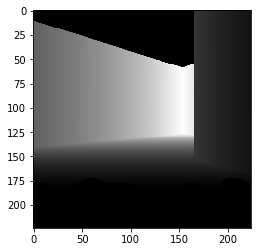

In [42]:
# train_images1
i = np.random.randint(len(drive_x)-1)
test(collision_model, drive_x[i])

[array([[0.3282358 , 0.30247465, 0.36928952]], dtype=float32),
 array([[0.52062577]], dtype=float32)]

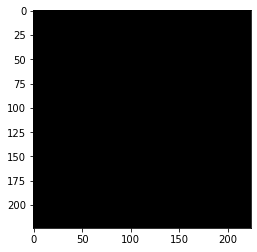

In [43]:
# train_images2
i = np.random.randint(len(col_x2)-1)
test(collision_model, col_x2[i])